# Positioning the Indoor Open Office UEs using Uplink ToA method

This tutorial estimates the position of based time of arrival estimates. The details of the tutorial simulation parameters is shown below:

|Parameters|Values|
| :- | -:  |
| Positioning Method  | UL-ToA (0.5-RTT :)) based  |
| Parameter Estimation Method  | ESPRIT  |
| Optimization Method | Least Squares |
| Carrier Frequency | 28 GHz |
| Bandwidth | 400 MHz |
| Subcarrier Spacing | 120 kHz|
| Terrain | Indoor-Open Office (InH-OO) |
|Channel State Information |Zero Forcing + Spline Interpolation|
| Reference Signal | Sounding Reference Signal for Positioning (SRS-P) |
|Simulation Type| System Level Simulation|

The tutorial will generate 5G standards compliant reference signal (PRS) which is transmitted by BS foe UE to perform measurement which inturn can be used to estimate the location of the UE. Users can generate the Wireless channel either using our tool which has one of the most exhaustive channel modelling library or use some other $3^{rd}$ party tool such as Sionna, Quadriga to generate the channel and use it with 5G Toolkit. 

***Positioning Procedure***

- Generate the Reference Signal
- Transmit the Reference Signal
- Pass the Transmit Signal through Wireless Channel
- Add Noise at the Receiver
- Estimate the Channel at Pilot Locations
- Interpolate the channel at remaining locations
- Estimate the Delays (Time of arrival using the channel Estimates)
- Estimate the Position using ToA estimates.
- Select the most accurate measurements for Positioning.
- Compute Time Difference of Arrival (TDoA) measurements.
- Estimate position of the UEs based on TDoA measurements.


Finally, we will demonstrate the efficacy of these methods using simulation evaluation results: 

- Horizontal (2D) Positioning Accuracy vs SNR
- Verical Positioning Accuracy vs SNR
- 3D Positioning Accuracy

## Python Libraries

In [1]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

import numpy      as np
import numpy.matlib
import scipy      as sp
import scipy.io   as spio
import scipy.constants
from   scipy import interpolate

## 5G Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../")

from toolkit5G.ChannelModels      import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator
from toolkit5G.ResourceMapping    import ResourceMapperSRS
from toolkit5G.ReceiverAlgorithms import ChannelEstimationSRS
from toolkit5G.Positioning        import ToAEstimation, PositionEstimation
from toolkit5G.ChannelProcessing  import AddNoise

## Simulation Parameters

In [3]:
## Simulation Parameters

propTerrain      = "InH-OO"         # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 28*10**9         # Array of two carrier frequencies in GHz
scs              = 120*10**3
Nfft             = 4096
numOfBSs         = np.array([6, 2]) # number of BSs
nBSs             = np.prod(numOfBSs)
nUEs             = 100             # number of UEs
numRBs           = 272
numSlots         = 1

## Generate Wireless Channels

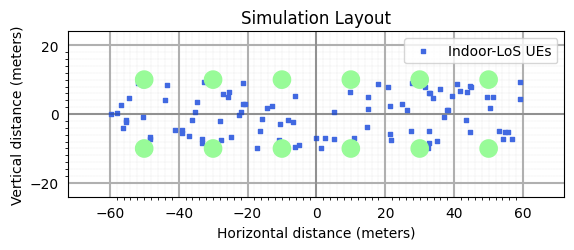

Channel Parameters Generated!
Channel Coefficient Generated!
OFDM Channel Generated!


In [4]:
## Generate the Wireless Channel

# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,2,2,1]))
ueAntArray()

# # Radiation Pattern of Rx antenna element
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,8,4,1]))
bsAntArray()

# # Radiation Pattern of Tx antenna element
# bsAntArray[0].displayAntennaRadiationPattern()

# Layout Parameters
isd                  = 20          # inter site distance
minDist              = 0          # min distance between each UE and BS
ueHt                 = 1.5         # UE height
bsHt                 = 5          # BS height
bslayoutType         = "Rectangular" # BS layout type
ueDropType           = "Rectangular" # UE drop type
htDist               = "equal"       # UE height distribution
ueDist               = "random"       # UE Distribution per site
nSectorsPerSite      = 1             # number of sectors per site
maxNumFloors         = 1             # Max number of floors in an indoor object
minNumFloors         = 1             # Min number of floors in an indoor object
heightOfRoom         = 5.1             # height of room or ceiling in meters
indoorUEfract        = 0.5           # Fraction of UEs located indoor
lengthOfIndoorObject = 3             # length of indoor object typically having rectangular geometry
widthOfIndoorObject  = 3             # width of indoor object
forceLOS             = True          # boolen flag if true forces every link to be in LOS state
# forceLOS             = False       # boolen flag if true forces every link to be in LOS state

# simulation layout object
simLayoutObj = SimulationLayout(numOfBS = numOfBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt,
                                ISD = isd,
                                layoutType = bslayoutType,
                                layoutWidth = 20,
                                layoutLength = 120,
                                ueDropMethod = ueDropType,
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None)

simLayoutObj(terrain = propTerrain,
             carrierFreq = carrierFrequency,
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             heightOfRoom = heightOfRoom,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject = widthOfIndoorObject,
             forceLOS = forceLOS)

# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_title("Simulation Topology")
ax.axhline(y=-0.5*isd*numOfBSs[1], xmin=10/140, xmax=130/140, color="k")
ax.axhline(y= 0.5*isd*numOfBSs[1], xmin=10/140, xmax=130/140, color="k")
ax.axvline(x=-0.5*isd*numOfBSs[0], ymin=10/140, ymax=130/140, color="k")
ax.axvline(x= 0.5*isd*numOfBSs[0], ymin=10/140, ymax=130/140, color="k")

paramGen = simLayoutObj.getParameterGenerator()
print("Channel Parameters Generated!")

# paramGen.displayClusters((0,0,0), rayIndex = 0)
channel = paramGen.getChannel()
print("Channel Coefficient Generated!")
Hf      = channel.ofdm(scs, Nfft)[0]
print("OFDM Channel Generated!")

Nt        = bsAntArray.numAntennas # Number of BS Antennas
Nr        = ueAntArray.numAntennas

## SRS Configurations

In [5]:
## SRS Configurations
purpose			    = "positioning"
nrofSRS_Ports		= 1
transmissionComb	= 4
nrofSymbols		    = 12
startPosition		= 2
repetitionFactor	= 1
nrOfCyclicShift		= 1
groupOrSequenceHopping	= "neither"
sequenceId		        = np.arange(nUEs)

systemFrameNumber	    = 0
resourceType		    = "periodic"
subcarrierSpacing 	    = scs

bSRS 			        = 0
cSRS 			        = 61
bHop 			        = 0

freqScalingFactor 	    = 1
startRBIndex 		    = 0
enableStartRBHopping 	= False
freqDomainShift 	    = 0
freqDomainPosition 	    = 0
srsPeriodicityInSlots 	= 1
srsOffsetInSlots 		= 0
betaSRS 		        = 1
resourceGridSizeinRBs 	= numRBs
Bandwidth               = resourceGridSizeinRBs*12*scs

## Slot by Slot Simulation

- Schedule a certain UEs for SRS transmission in each slot.
- Beamform the slot Grid.
- Pass the beamformed Grid through the wireless channel.
    - Consider inter-user interference.
- Extract the resource Grid.
- Estimate the channel between the scheduled users and each BS.
    - Estimate the channel using LS estimator.
    - Interpolate the channel for un-scheduled REs in the slot Grid.
- Estimate the time of arrival (ToA) for each UE-BS link.

In [6]:
print("***********  Transmission Grid Beamformed *********** ")
numRepetition    = 1
numSlotsPerFrame = np.int32(10*(15000/scs))
numUEsPerSlot    = transmissionComb
numSlots         = np.int32(np.ceil(nUEs*numRepetition/transmissionComb))
frameIndices     = np.int32(np.floor(np.arange(numUEsPerSlot*numRepetition)/transmissionComb)%numSlotsPerFrame)
slotIndices      = np.int32(np.floor(np.floor(np.arange(numUEsPerSlot*numRepetition)/transmissionComb)/numSlotsPerFrame))
combOffset       = np.int32(np.arange(numUEsPerSlot))

ToAe              = np.zeros((nBSs,nUEs))

for ns in range(numSlots):
    
    ## SRS Grid Generation

    srsGrid      = np.zeros((numUEsPerSlot, 14, numRBs*12), dtype=np.complex64)
    srsObject    = np.empty((numUEsPerSlot), dtype=object)

    for nue in range(numUEsPerSlot):
        srsObject[nue]   = ResourceMapperSRS(nrofSRS_Ports, transmissionComb, nrofSymbols, startPosition,
                                             repetitionFactor, nrOfCyclicShift, groupOrSequenceHopping, 
                                             sequenceId[nue], combOffset[nue], ns, frameIndices[nue], 
                                             resourceType, purpose, subcarrierSpacing)

        srsGrid[nue] = srsObject[nue](bSRS, cSRS, bHop, freqScalingFactor, startRBIndex, 
                                          enableStartRBHopping, freqDomainShift, freqDomainPosition, 
                                          srsPeriodicityInSlots, srsOffsetInSlots, betaSRS, 
                                          resourceGridSizeinRBs)[0,0,0]

    XGrid     = np.zeros((numUEsPerSlot, 14, Nfft), dtype=np.complex64)
    bwpOffset = np.random.randint(Nfft-resourceGridSizeinRBs*12)

    ## Load the resource grid to Transmission Grid
    XGrid[...,bwpOffset:(bwpOffset+resourceGridSizeinRBs*12)] = srsGrid

    print("***********  Transmission Grid Generated *********** ")

    del srsGrid

    ## Beamforming
    # Beamforming angles
    # Inter-element spacing in vertical and horizontal
    Pt_dBm= 23
    Pt    = 10**(0.1*(Pt_dBm-30))
    lamda = 3*10**8/carrierFrequency
    d     = 0.5/lamda
    theta = 0
    # Wt    = np.sqrt(Pt/Nt)*np.exp(1j*2*np.pi*d*np.cos(theta)/(lamda*Nt)*np.arange(0,Nt))
    # Xf    = Wt.reshape(-1,1,1)*XGrid1
    Xf    = (transmissionComb*Pt/Nr)*XGrid[..., np.newaxis].repeat(Nr, axis = -1)
    del XGrid
    
    ueIndices     = np.arange(ns*numUEsPerSlot, (ns+1)*numUEsPerSlot)
    ## Pass through channel
    Yf = (Hf[:,:,ueIndices].transpose(1,2,0,3,5,4)@Xf[np.newaxis,...,np.newaxis]).sum(1)

    print("***********  ["+str(ns)+"]-Passed Through Channel *********** ")

    ## Add Noise
    BoltzmanConst = 1.380649*(10**(-23))
    temperature   = 300
    noisePower    = BoltzmanConst*temperature*scs
#     noisePower    = 0
    kppm          = 0
    fCFO          = kppm*(np.random.rand()-0.5)*carrierFrequency*(10**(-6)); # fCFO = CFO*subcarrierSpacing
    CFO           = (fCFO/scs)/Nfft
    ##Yf            = AddNoise(True)(Y, noisePower, CFO)

    # Yf            = AddNoise(False)(Y, noisePower, 0)    #Added
    Yf            = np.complex64(Yf + np.sqrt(0.5*noisePower)*(np.random.standard_normal(Yf.shape) + 1j*np.random.standard_normal(Yf.shape)))

    ## Extract Resource Grid
    rxGrid = Yf[...,bwpOffset:(bwpOffset+resourceGridSizeinRBs*12),:,0].transpose(0,3,1,2)

    print("***********  ["+str(ns)+"]-Resource Grid Extracted *********** ")

    ## Channel Estimation and Interpolation
    Hfest  = np.zeros((nBSs, numUEsPerSlot, Nt, 14, rxGrid.shape[-1]), dtype = np.complex64)
    chEST  = ChannelEstimationSRS()
    chGrid = rxGrid.reshape(nBSs*Nt,14,-1)[:,np.newaxis,np.newaxis,np.newaxis]

    interpolatorType = "Linear" # "Spline", "Linear", "Cubic"

    for nue in range(numUEsPerSlot):
#         print("UE-Index: "+str(ueIndices[nue])+" | slot-Index: "+str(ns))

        Hfest[:,nue] = chEST(chGrid, srsObject[nue], interpolatorType)[:,0,0,0].reshape(nBSs,Nt,14,-1)

    Hest = Hfest.sum(-2)/14

    print("***********  ["+str(ns)+"]-Channel Estimated *********** ")

    ## ToA Estimation
    toaEstimation = ToAEstimation("ESPRIT", Hest[0, 0].T.shape)
    
    
    Lpath         = 2
    for nbs in range(nBSs):
        for nue in range(numUEsPerSlot):
#             print("(nbs, nue): ("+str(nbs)+", "+str(ueIndices[nue])+")")
            delayEstimates = np.sort(toaEstimation(Hest[nbs, nue].T,
                                                   Lpath,
                                                   subCarrierSpacing = scs))
            delayEstimates = delayEstimates[delayEstimates > 0]
            K = Lpath
            while((delayEstimates.size==0) or (delayEstimates[0]<=0 and K < 12)):
                K = K + 1
                delayEstimates = np.sort(toaEstimation(Hest[nbs, nue].T,
                                                       numberOfPath = K,
                                                       subCarrierSpacing = scs))
                delayEstimates = delayEstimates[delayEstimates > 0]
            if(delayEstimates.size == 0):
                ToAe[nbs, ueIndices[nue]] = 10**-9
            else:
                ToAe[nbs, ueIndices[nue]] = delayEstimates[0]

    print("***********  ["+str(ns)+"]-ToA Estimated *********** ")    



***********  Transmission Grid Beamformed *********** 
***********  Transmission Grid Generated *********** 
***********  [0]-Passed Through Channel *********** 
***********  [0]-Resource Grid Extracted *********** 
***********  [0]-Channel Estimated *********** 
***********  [0]-ToA Estimated *********** 
***********  Transmission Grid Generated *********** 
***********  [1]-Passed Through Channel *********** 
***********  [1]-Resource Grid Extracted *********** 
***********  [1]-Channel Estimated *********** 
***********  [1]-ToA Estimated *********** 
***********  Transmission Grid Generated *********** 
***********  [2]-Passed Through Channel *********** 
***********  [2]-Resource Grid Extracted *********** 
***********  [2]-Channel Estimated *********** 
***********  [2]-ToA Estimated *********** 
***********  Transmission Grid Generated *********** 
***********  [3]-Passed Through Channel *********** 
***********  [3]-Resource Grid Extracted *********** 
***********  [3]-Channel 

## Position Estimation: Based on UL-ToA

In [8]:
## Position Estimation
rxPosition  = simLayoutObj.UELocations
txPosition  = simLayoutObj.BSLocations

k         = 4  # Select k-best measurements
error     = (np.abs(ToAe-channel.delays[0,0,...,0])/channel.delays[0,0,...,0]) # Compute the ToA error in each measurement
bsIndices = (np.argsort(error,axis=0)[0:k]).T

positionEstimate = PositionEstimation(positioningMethod = "TOA", optimizationMethod = "LeastSquare")
# Position Estimation Object:
    # Positioning based on: ToA
    # Optimization Method: Least Square

rxPositionEstimate = np.zeros((nUEs,2,3))
rxStdEstimate      = np.zeros((nUEs))
kBestIndices       = np.zeros((nUEs, k), dtype = np.int8)

for nue in range(nUEs):
    rxPositionEstimate[nue] = positionEstimate(txPosition[bsIndices[nue]], toa = ToAe[bsIndices[nue],nue])
    print("nue: "+str(nue)+" | Rx Location Estimate: "+str(rxPositionEstimate[nue,0]))


nue: 0 | Rx Location Estimate: [-10.4215363   -2.78032138   1.50797252]
nue: 1 | Rx Location Estimate: [-56.16600051  -3.90443573   1.47474593]
nue: 2 | Rx Location Estimate: [21.74856967 -7.4471635   1.54521712]
nue: 3 | Rx Location Estimate: [-27.55050478  -7.43931444   1.13662121]
nue: 4 | Rx Location Estimate: [-27.85489926  -2.08774903   1.52755895]
nue: 5 | Rx Location Estimate: [-51.82279784   9.13361618   1.52349518]
nue: 6 | Rx Location Estimate: [54.5575103  -5.19681135  1.26737552]
nue: 7 | Rx Location Estimate: [54.60794566 -6.99476197  1.36027376]
nue: 8 | Rx Location Estimate: [-50.31028088  -0.81732425   1.54359212]
nue: 9 | Rx Location Estimate: [ 2.52461434 -6.94843593  1.63401437]
nue: 10 | Rx Location Estimate: [17.94944578  8.86232628  1.53715152]
nue: 11 | Rx Location Estimate: [-35.19626289   0.6363511    1.54316006]
nue: 12 | Rx Location Estimate: [-15.7766177   -1.35418832   1.55182393]
nue: 13 | Rx Location Estimate: [32.43763633 -9.87677854  1.62842819]
nue: 1

## Visualization of Estimated Position

``Note``: This visualization requires intractive matplotlib. Please uncomment **%matplotlib widget** from first codeblock.

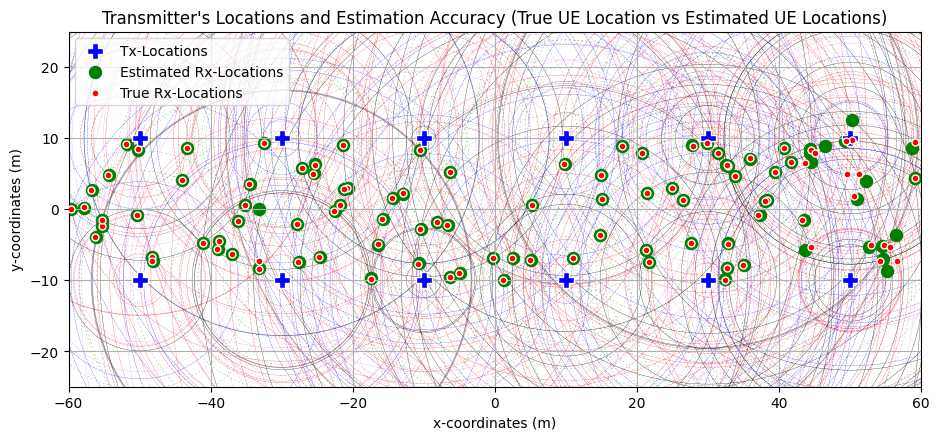

In [9]:

#################################################################
rxPosition  = simLayoutObj.UELocations
txPosition  = simLayoutObj.BSLocations
rangeEst_2D = np.sqrt(np.abs((ToAe*(3*10**8))**2 - (rxPosition[:,2].reshape(1,-1)-txPosition[:,2].reshape(-1,1))**2))

fig, ax = plt.subplots(figsize=(11,5.5))
ax.set_aspect(True)
# fig, ax = simLayoutObj.display2DTopology(isEqualAspectRatio = True)
colors  = ["k","m","r","b","g","y","crimson"]

linestyle_tuple = ['solid', 'dotted', 'dashed', 'dashdot',
                   (0, (5, 10)),                # 'loosely dashed'
                   (0, (1, 10)),                # 'loosely dotted'
                   (5, (10, 3)),                # 'long dash with offset'
                   (0, (5, 1)),                 # 'densely dashed'
                   (0, (3, 10, 1, 10)),         # 'loosely dashdotted'
                   (0, (3, 5, 1, 5)),           # 'dashdotted'
                   (0, (3, 1, 1, 1)),           # 'densely dashdotted'
                   (0, (3, 5, 1, 5, 1, 5)),     # 'dashdotdotted'
                   (0, (3, 10, 1, 10, 1, 10)),  # 'loosely dashdotdotted'
                   (0, (3, 1, 1, 1, 1, 1))]     # 'densely dashdotdotted'

for nbs in range(k):
    for nue in range(nUEs):
            circle1 = plt.Circle((txPosition[bsIndices[nue, nbs], 0], txPosition[bsIndices[nue, nbs], 1]), rangeEst_2D[bsIndices[nue, nbs], nue],
                                 color = colors[nue%7], lw = 0.2, ls = linestyle_tuple[nue%7], fill = False, zorder = 0)
            ax.add_artist(circle1)

ax.scatter(txPosition[:,0], txPosition[:,1], marker="P", color="b", edgecolors='white',
           s = 125, label="Tx-Locations", zorder = 3)
ax.scatter(rxPositionEstimate[:,0,0], rxPositionEstimate[:,0,1], marker="o", color="g",
           s = 75, label="Estimated Rx-Locations", zorder = 1)
ax.scatter(rxPosition[:,0], rxPosition[:,1], marker=".", color="r", edgecolors='white',
           s = 100, label="True Rx-Locations", zorder = 5)
ax.legend()
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_title("Transmitter's Locations and Estimation Accuracy (True UE Location vs Estimated UE Locations)")
ax.set_xlim([-60, 60])
ax.set_ylim([-25, 25])
ax.grid(True)
plt.show()

## Performance Analysis of Positioning Error for Uplink-ToA based method

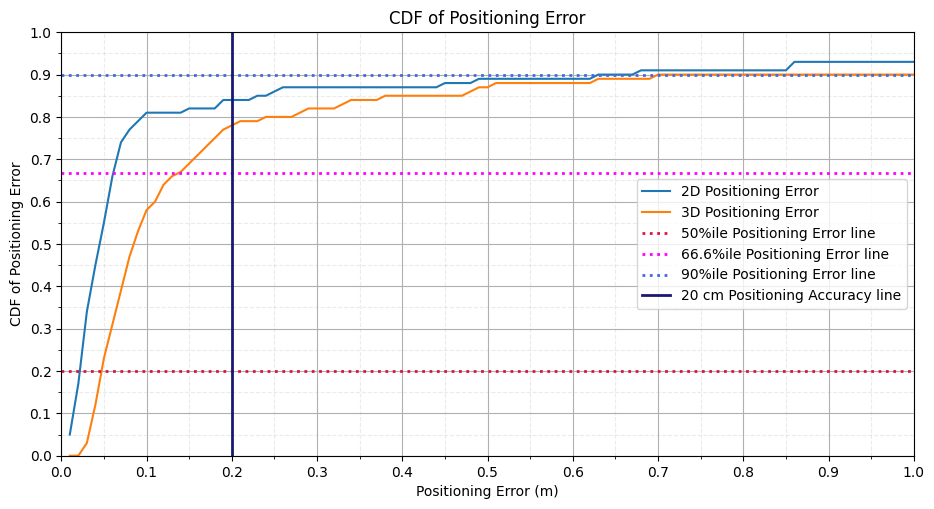

In [10]:
nbins = nUEs
xlimit = 1
ylimit = 1
posError3D = np.linalg.norm(rxPositionEstimate[:, 0]-rxPosition[:], axis=1)
posError3D = np.where(np.isnan(posError3D), 0, posError3D)
posError2D = np.linalg.norm(rxPositionEstimate[:, 0, 0:2]-rxPosition[:, 0:2], axis=1)

# Horizontal Error
count, bins_count = np.histogram(posError2D, bins = nbins, range = [0, 1])
pdf = count/nUEs
cdf = np.cumsum(pdf)

fig, ax = plt.subplots(figsize=(11,5.5))
ax.plot(bins_count[1:], cdf, label = "2D Positioning Error")



# Vertical Error
count, bins_count = np.histogram(posError3D, bins = nbins, range = [0, 1])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf, label = "3D Positioning Error")

ax.set_xticks(np.linspace(0, xlimit, 11))
ax.set_xticks(np.linspace(0, xlimit, 21), minor=True)
ax.set_yticks(np.linspace(0, ylimit, 11))
ax.set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax.set_xlabel("Positioning Error (m)")
ax.set_ylabel("CDF of Positioning Error")
ax.set_title("CDF of Positioning Error")
ax.axhline(y = 0.2, lw = 2, alpha = 1, linestyle = ':', color = "crimson", label = "50%ile Positioning Error line")
ax.axhline(y = 2/3, lw = 2, alpha = 1, linestyle = ':', color = "magenta", label = "66.6%ile Positioning Error line")
ax.axhline(y = 0.9, lw = 2, alpha = 1, linestyle = ':', color = "royalblue", label = "90%ile Positioning Error line")
ax.axvline(x = 0.2, lw = 2, alpha = 1, linestyle = '-', color = "midnightblue", label = "20 cm Positioning Accuracy line")

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlim([0,xlimit])
ax.set_ylim([0,ylimit])
ax.legend()
plt.show()

# # Code to save the Database
# idx  = 0
# flag = True
# while(flag):
#     print("flag: "+str(idx)+" | i="+str(idx))
#     filename = "Databases/ULToA-"+str([idx])+".npz"
#     if(os.path.exists(filename)):
#         idx  = idx + 1
#     else:
#         np.savez(filename, posError3D = posError3D, posError2D = posError2D, 
#                  rxPositionEstimate = rxPositionEstimate, rxPosition = rxPosition, 
#                  ToAe = ToAe, txPosition = txPosition, propTerrain = propTerrain, 
#                  carrierFrequency = carrierFrequency, scs = scs, Nfft = Nfft, 
#                  nBSs = nBSs, nUEs = nUEs, numRBs = numRBs, 
#                  bsArrayStructure  = bsAntArray.arrayStructure, 
#                  ueArrayStructure  = ueAntArray.arrayStructure)
#         flag = False
        

## Performance Analysis: For 2000 UEs

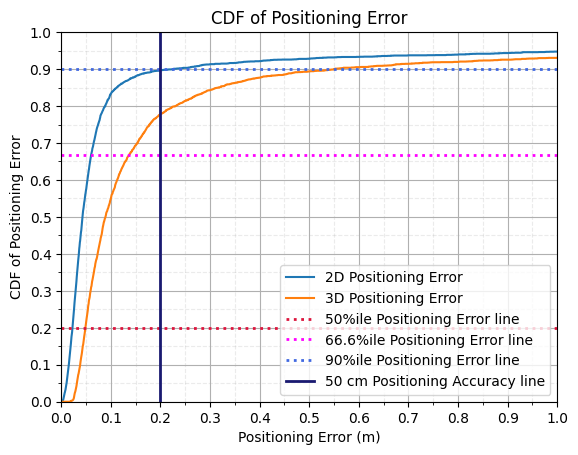

In [11]:
filename = "Databases/ULToA-"+str([0])+".npz"
ds       = np.load(filename)

posError3D = ds["posError3D"]
posError2D = ds["posError2D"]

for i in range(1,11):
    
    filename   = "Databases/ULToA-"+str([i])+".npz"
    ds         = np.load(filename)
    
    posError3D = np.concatenate([posError3D, ds["posError3D"]])
    posError2D = np.concatenate([posError2D, ds["posError2D"]])

nbins = posError2D.size
xlimit = 1
ylimit = 1

# Horizontal Error
count, bins_count = np.histogram(posError2D, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)

fig, ax = plt.subplots()
ax.plot(bins_count[1:], cdf, label = "2D Positioning Error")



# Vertical Error
count, bins_count = np.histogram(posError3D, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf, label = "3D Positioning Error")

ax.set_xticks(np.linspace(0, xlimit, 11))
ax.set_xticks(np.linspace(0, xlimit, 21), minor=True)
ax.set_yticks(np.linspace(0, ylimit, 11))
ax.set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax.set_xlabel("Positioning Error (m)")
ax.set_ylabel("CDF of Positioning Error")
ax.set_title("CDF of Positioning Error")
ax.axhline(y = 0.2, lw = 2, alpha = 1, linestyle = ':', color = "crimson", label = "50%ile Positioning Error line")
ax.axhline(y = 2/3, lw = 2, alpha = 1, linestyle = ':', color = "magenta", label = "66.6%ile Positioning Error line")
ax.axhline(y = 0.9, lw = 2, alpha = 1, linestyle = ':', color = "royalblue", label = "90%ile Positioning Error line")
ax.axvline(x = 0.2,lw = 2, alpha = 1, linestyle = '-', color = "midnightblue", label = "50 cm Positioning Accuracy line")

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlim([0,xlimit])
ax.set_ylim([0,ylimit])
ax.legend()
plt.show()